<a href="https://colab.research.google.com/github/GSaiLahari/BirdsVsDrones/blob/main/PytorchBvD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/Archive.zip

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [4]:
data_dir = '/content/BirdVsDrone'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.RandomRotation(30), 
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
    val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
    
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=val_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, val_idx, test_idx = indices[(2*split):], indices[:split], indices[split:(2*split)]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    valloader = torch.utils.data.DataLoader(val_data, sampler=val_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, valloader, testloader

trainloader, valloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

10
['Birds', 'Drones']


In [6]:
from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
device

device(type='cuda')

In [8]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
epochs = 15
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
    steps += 1
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0
      model.eval()
      with torch.no_grad():
        for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model.forward(inputs)
          batch_loss = criterion(logps, labels)
          test_loss += batch_loss.item()
          
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(valloader))
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/print_every:.3f}.. "
            f"Test loss: {test_loss/len(valloader):.3f}.. "
            f"Test accuracy: {accuracy/len(valloader):.3f}")
      running_loss = 0
      model.train()

Epoch 1/15.. Train loss: 0.815.. Test loss: 0.265.. Test accuracy: 0.941
Epoch 2/15.. Train loss: 0.553.. Test loss: 0.391.. Test accuracy: 0.840
Epoch 3/15.. Train loss: 0.381.. Test loss: 0.170.. Test accuracy: 0.953
Epoch 4/15.. Train loss: 0.191.. Test loss: 0.139.. Test accuracy: 0.965
Epoch 5/15.. Train loss: 0.143.. Test loss: 0.139.. Test accuracy: 0.957
Epoch 6/15.. Train loss: 0.212.. Test loss: 0.304.. Test accuracy: 0.870
Epoch 7/15.. Train loss: 0.143.. Test loss: 0.172.. Test accuracy: 0.949
Epoch 8/15.. Train loss: 0.159.. Test loss: 0.173.. Test accuracy: 0.949
Epoch 9/15.. Train loss: 0.158.. Test loss: 0.185.. Test accuracy: 0.915
Epoch 10/15.. Train loss: 0.133.. Test loss: 0.241.. Test accuracy: 0.934
Epoch 11/15.. Train loss: 0.187.. Test loss: 0.147.. Test accuracy: 0.953
Epoch 12/15.. Train loss: 0.127.. Test loss: 0.186.. Test accuracy: 0.927
Epoch 13/15.. Train loss: 0.116.. Test loss: 0.217.. Test accuracy: 0.957
Epoch 14/15.. Train loss: 0.175.. Test loss: 0.

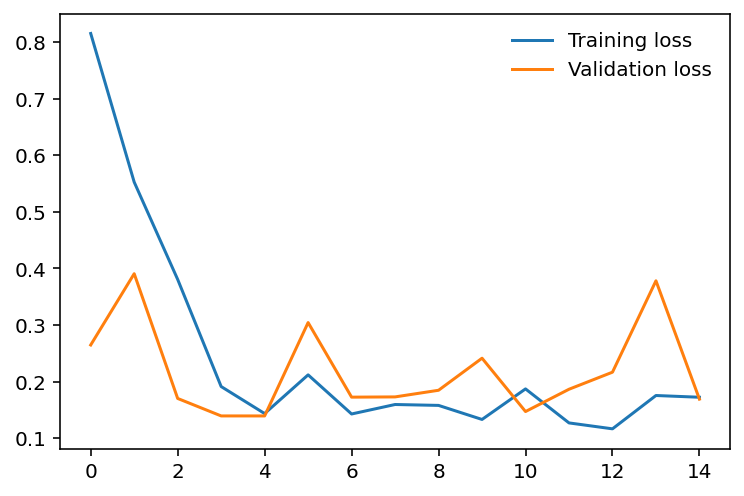

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [11]:
from torch.autograd import Variable
model.eval()
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

In [12]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels

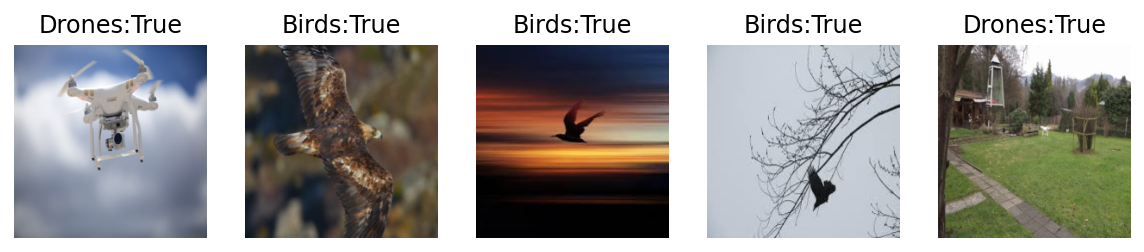

In [13]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(trainloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

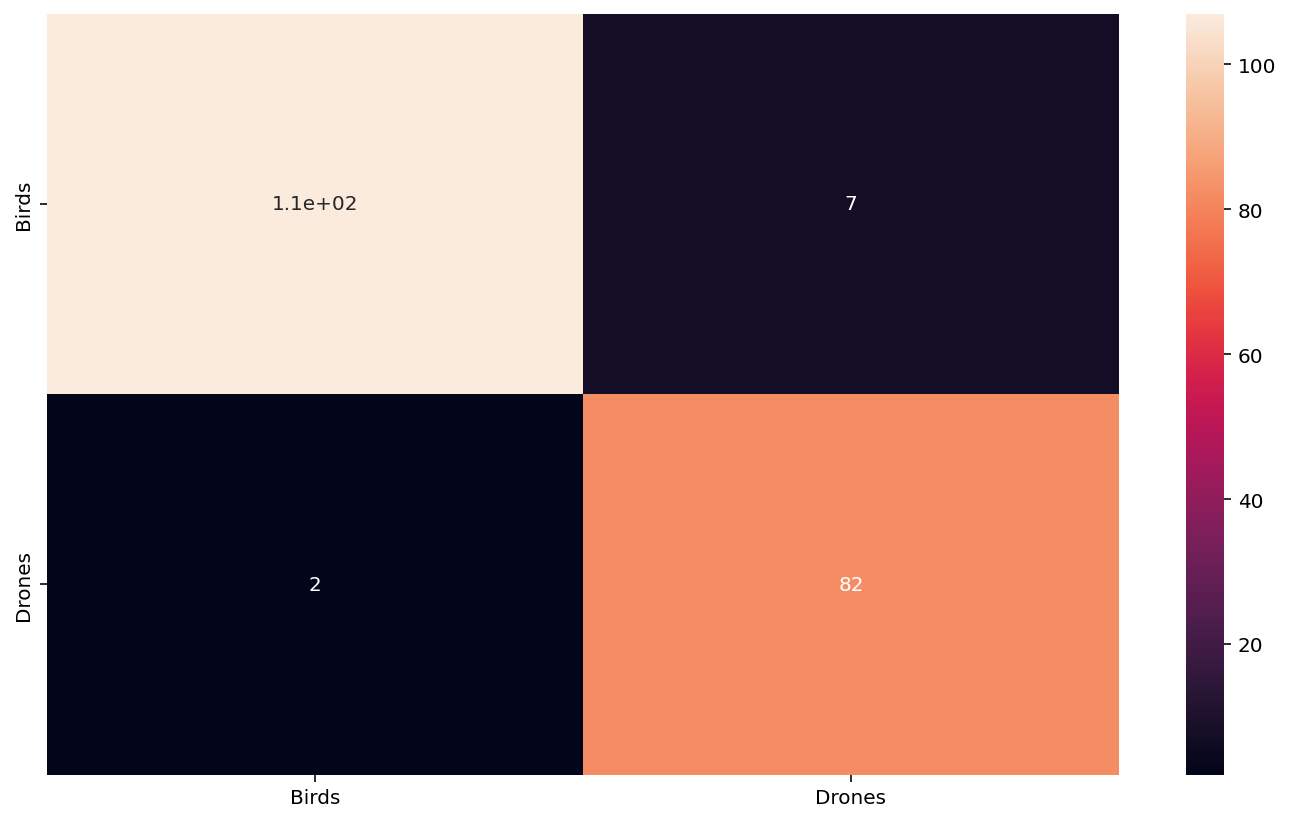

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = trainloader.dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [15]:
torch.save(model, "model.pth")